In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

In [ ]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [5]:
# clinical data
clin = pd.read_csv('data/NCT01621490_bms038_clinical_data.csv')
# convert the patient id and sample name to lower case
clin['PatientID'] = clin['PatientID'].str.lower()
clin['Sample'] = clin['Sample'].str.lower()

# bbulk expression data
ge_file = 'data/NCT01621490_advmel_rnaseq_voom.txt'
ge = pd.read_table(ge_file,index_col=0)

# Get only overlap samples
overlap_patients = set(clin.PatientID) & set(ge.columns) 
ge = ge.loc[:, ge.columns.isin(overlap_patients)]
clin = clin.loc[clin.PatientID.isin(overlap_patients),:]

In [10]:
clin.head(2)

,PatientID,Sample,SampleType,Cohort,SubtypeEZ,TRTGRP,BOR,myBOR,PFS_SOR,OS_SOR,OS,OSWK,IBOR,PFS,PFSWK,myBOR2,myBOR3
0,pt1,pt1_pre,pre,NIV3-PROG,NaN,NIV3-PROG,PD,PD,0,0,160,22.857143,PROGRESSION,54,7.714286,PD,SDPD
1,pt10,pt10_pre,pre,NIV3-NAIVE,NF1,NIV3-NAIVE,SD,SD,0,0,256,36.571429,STABLE DISEASE,119,17.000000,PRCRSD,SDPD


In [11]:
clin.shape

(41, 17)

In [9]:
ge

,pt101,pt106,pt10,pt17,pt18,pt1,pt23,pt24,pt26,pt27,...,pt77,pt78,pt79,pt84,pt85,pt8,pt92,pt94,pt98,pt9
A1BG,2.4964,2.4522,2.1349,2.0473,1.6207,3.2712,1.7644,2.2095,1.6802,2.3777,...,2.0478,2.3201,1.9896,0.0684,3.9822,2.8355,0.9502,2.9335,2.8099,1.6085
NAT2,-6.6303,-3.9229,-7.1248,-6.4406,-6.5642,-6.4986,-3.2993,-6.1699,-6.4336,-6.1731,...,-6.5182,-5.9973,-4.2315,-2.7390,-4.0872,-6.5243,-6.3072,-4.6030,-6.3116,-2.4336
ADA,5.0408,3.9145,3.8155,2.5049,4.6188,3.6448,4.0825,3.4170,0.5322,0.7694,...,4.2071,5.6452,3.6694,1.7264,2.8269,3.3197,4.1347,3.8441,2.4197,2.7510
CDH2,2.2058,5.8745,2.2782,-0.2507,6.2850,0.6613,6.8032,3.0469,1.9545,5.6953,...,4.4206,1.7643,3.0668,2.5124,7.5203,2.8178,3.8156,2.1474,2.2620,6.6034
AKT3,5.6490,7.4732,8.2924,5.0923,6.8556,7.2409,6.4299,5.8071,7.8371,7.4981,...,7.4471,8.1557,7.6094,5.1880,8.7902,7.3299,7.0494,7.0862,7.1741,7.2486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PTBP3,7.6388,6.5576,7.3153,8.1428,7.1405,6.8296,6.8961,7.9210,7.0899,7.0574,...,7.2058,6.1617,5.9502,6.7255,6.3745,6.4965,6.8679,6.6690,6.6119,6.3593
KCNE2,-2.3823,-1.3727,-2.0804,1.1668,-2.1719,-0.8839,0.1890,-2.4694,-1.7897,-0.3917,...,-2.2703,-0.6397,-2.8530,-0.3655,0.5334,-0.6914,-0.5258,-1.4331,-1.5567,-0.7989
DGCR2,6.0366,6.0319,6.6564,6.1872,5.4177,6.1468,6.8441,5.1458,5.9612,5.4847,...,6.1992,5.7157,5.8284,6.2427,5.8667,6.0373,6.8427,6.1868,5.9942,5.8081
CASP8AP2,5.6156,4.5604,4.7005,5.4363,5.2322,5.1600,4.7566,5.1161,5.7348,4.9137,...,4.8121,5.3934,4.4403,4.5557,4.7260,4.5810,4.9567,4.4550,4.0492,4.6148


In [21]:
receiver = pd.read_csv(
    "data/GSE120575_DE_table_receiver.csv", 
    index_col='gene'
)
receiver = receiver.sort_values('p_val_adj')
receiver

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
gene,,,,,
GAPDH,1.581859e-142,-1.071368,0.904,0.979,7.258200e-138
RP5-940J5.9,1.331643e-115,-1.020473,0.872,0.970,6.110109e-111
NKG7,2.071915e-109,-0.904104,0.688,0.916,9.506776e-105
PRF1,1.060346e-107,-1.046101,0.514,0.792,4.865294e-103
CD38,5.430308e-95,-1.479788,0.189,0.466,2.491643e-90
...,...,...,...,...,...
SRP54,2.941787e-02,0.285397,0.229,0.262,1.000000e+00
MAF,2.943913e-02,0.379672,0.181,0.209,1.000000e+00
CBX7,2.952318e-02,0.671168,0.145,0.126,1.000000e+00


In [16]:
ligand = pd.read_csv("data/GSE120575_vis_ligand_lfc.csv", 
                     index_col=0)
ligand

,B.cells,Macrophages,Memory.CD4.T.cells,NK.cells,Regulatory.CD4.T.cells
TNFSF12,0.000000,0.355731,0.000000,0.000000,0.000000
MMP9,0.000000,-1.526165,0.000000,0.000000,0.000000
CD80,0.000000,-1.213554,0.000000,0.000000,0.000000
CCL3L3,0.000000,-0.072866,0.000000,-7.555815,0.000000
HLA.G,-0.615325,0.134741,-0.221957,-0.485473,-0.114004
ADAM17,0.093314,0.000000,-0.330620,-0.943627,0.333532
CD28,0.000000,0.000000,0.201190,-0.125290,0.529325
TGFB1,0.000000,-0.314154,0.698312,-5.216949,0.572606
PDCD1LG2,0.000000,0.405266,0.000000,0.000000,0.000000
TNFSF13B,0.000000,0.061281,0.000000,0.000000,0.000000


In [101]:
target = pd.read_csv("data/GSE120575_vis_ligand_target.csv", 
                     index_col=0)
target

,ATF3,BAX,BCL2L1,CASP1,CCL3,CCL4,CCL5,CCR5,CCR7,FAS,...,VDAC1,ALOX5AP,TRAF2,CD74,EPB41,LSM2,ENO1,ATP5D,CAPN2,LASP1
TNFSF12,0.001890,0.000000,0.001740,0.000000,0.000000,0.000000,0.002995,0.000000,0.001620,0.001346,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001632
MMP9,0.001360,0.003647,0.004005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD80,0.000000,0.000000,0.001418,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CCL3L3,0.000000,0.001357,0.001646,0.000000,0.000000,0.000000,0.002581,0.000000,0.001362,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001426,0.000000,0.000000,0.000000
HLA.G,0.000000,0.000000,0.001364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ADAM17,0.001418,0.000000,0.001766,0.000000,0.000000,0.000000,0.002425,0.000000,0.000000,0.002553,...,0.000000,0.002516,0.002356,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD28,0.001335,0.000000,0.002791,0.000000,0.000000,0.000000,0.000000,0.000000,0.001379,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TGFB1,0.001737,0.005013,0.001763,0.000000,0.006764,0.000000,0.004352,0.000000,0.001549,0.002546,...,0.004307,0.002733,0.000000,0.000000,0.001421,0.000000,0.001374,0.001362,0.001366,0.001414
PDCD1LG2,0.000000,0.000000,0.001338,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TNFSF13B,0.000000,0.000000,0.002484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002280,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [102]:
target.transpose()

,TNFSF12,MMP9,CD80,CCL3L3,HLA.G,ADAM17,CD28,TGFB1,PDCD1LG2,TNFSF13B,IL15,APOE,TNF,CCL3,CCL2,LTA,ICAM1,CD40LG,HMGB2,IFNG
ATF3,0.001890,0.001360,0.000000,0.000000,0.000000,0.001418,0.001335,0.001737,0.000000,0.000000,0.001999,0.000000,0.002588,0.001552,0.000000,0.001415,0.000000,0.001654,0.001639,0.004814
BAX,0.000000,0.003647,0.000000,0.001357,0.000000,0.000000,0.000000,0.005013,0.000000,0.000000,0.001465,0.000000,0.004694,0.000000,0.003595,0.000000,0.000000,0.001513,0.000000,0.004004
BCL2L1,0.001740,0.004005,0.001418,0.001646,0.001364,0.001766,0.002791,0.001763,0.001338,0.002484,0.004495,0.000000,0.005141,0.001812,0.001448,0.001913,0.001383,0.001952,0.001469,0.003051
CASP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007631
CCL3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006764,0.000000,0.000000,0.002769,0.004725,0.002427,0.001628,0.004868,0.000000,0.000000,0.000000,0.000000,0.006848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LSM2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001339,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENO1,0.000000,0.000000,0.000000,0.001426,0.000000,0.000000,0.000000,0.001374,0.000000,0.000000,0.001592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001569
ATP5D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001362,0.000000,0.000000,0.001493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001538
CAPN2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001366,0.000000,0.000000,0.001361,0.000000,0.002530,0.001339,0.000000,0.000000,0.000000,0.000000,0.000000,0.001374


In [104]:
def get_score_table(gene_df, ge, n_select, in_row_col='row'):
    if in_row_col=='col':
        gene_df = gene_df.transpose()
    select = gene_df.iloc[:n_select,]
    # find common genes in both select df and ge df
    # to make sure the genes are in the index of select
    # when slicing the select df
    common = list(set(select.index).intersection(ge.index))
    select = select.iloc[select.index.isin(common),]
    score_table = ge.loc[select.index,].mean(
        axis=0
    ).reset_index()
#     else:
#         select = gene_df.iloc[, :n_select]
#         common = list(set(select.columns).intersection(ge.index))
#         select = select.iloc[, select.columns.isin(common)]
#         score_table = ge.loc[select.columns,].mean(
#             axis=0
#         ).reset_index()
    score_table.columns = ["PatientID", "Score"]
    return select, score_table

In [112]:
def bor_boxplot(data, fig_size1=6, fig_size2=6):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_size1, fig_size2)
    sns.boxplot(x="BOR", 
                y="Score", data=data, 
                order=["PD", "SD", "PR", "CR"], 
                fliersize=0, ax=ax)
    sns.swarmplot(x="BOR", 
                  y="Score", 
                  data=data, 
                  order=["PD", "SD", "PR", "CR"], 
                  color=".2", alpha=0.5, ax=ax)
    ax.set_ylabel("Mean expression")
    ax.set_xlabel("Best overall response")

In [114]:
def get_mat(data):
    mat = data[["PatientID", "PFS", "PFS_SOR", "Score"]].copy()
    # PFS_SOR indicates whether the time to event has been censored
    # so we need to do 1 - PFS_SOR to get the event indicator
    mat["pfs_event"] = 1 - mat["PFS_SOR"]
    mat.drop("PFS_SOR", axis=1, inplace=True)
    mat.set_index("PatientID", inplace=True)
    return mat

In [116]:
def kmf_plot(mat, fig_size1=3, fig_size2=3):
    kmf = KaplanMeierFitter()

    fig, ax = plt.subplots(dpi=150, 
                           figsize=(fig_size1, fig_size2))

    high_idx = mat.Score >= mat.Score.median()

    kmf.fit(mat.PFS[high_idx], mat.pfs_event[high_idx],
            label="High expression")
    kmf.plot(ax=ax, ci_show=False)
    kmf.fit(mat.PFS[~high_idx], mat.pfs_event[~high_idx],
            label="Low expression")
    
    kmf.plot(ax=ax, ci_show=False)

### Use target genes to predict

In [107]:
select, score_table = get_score_table(gene_df=target, 
                              ge=ge, 
                              n_select=target.shape[1], 
                              in_row_col='col')

In [108]:
select

,TNFSF12,MMP9,CD80,CCL3L3,HLA.G,ADAM17,CD28,TGFB1,PDCD1LG2,TNFSF13B,IL15,APOE,TNF,CCL3,CCL2,LTA,ICAM1,CD40LG,HMGB2,IFNG
ATF3,0.001890,0.001360,0.000000,0.000000,0.000000,0.001418,0.001335,0.001737,0.000000,0.000000,0.001999,0.000000,0.002588,0.001552,0.000000,0.001415,0.000000,0.001654,0.001639,0.004814
BAX,0.000000,0.003647,0.000000,0.001357,0.000000,0.000000,0.000000,0.005013,0.000000,0.000000,0.001465,0.000000,0.004694,0.000000,0.003595,0.000000,0.000000,0.001513,0.000000,0.004004
BCL2L1,0.001740,0.004005,0.001418,0.001646,0.001364,0.001766,0.002791,0.001763,0.001338,0.002484,0.004495,0.000000,0.005141,0.001812,0.001448,0.001913,0.001383,0.001952,0.001469,0.003051
CASP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007631
CCL3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006764,0.000000,0.000000,0.002769,0.004725,0.002427,0.001628,0.004868,0.000000,0.000000,0.000000,0.000000,0.006848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LSM2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001339,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENO1,0.000000,0.000000,0.000000,0.001426,0.000000,0.000000,0.000000,0.001374,0.000000,0.000000,0.001592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001569
ATP5D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001362,0.000000,0.000000,0.001493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001538
CAPN2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001366,0.000000,0.000000,0.001361,0.000000,0.002530,0.001339,0.000000,0.000000,0.000000,0.000000,0.000000,0.001374


In [123]:
select.index.tolist()[:55]

['ATF3',
 'BAX',
 'BCL2L1',
 'CASP1',
 'CCL3',
 'CCL4',
 'CCL5',
 'CCR5',
 'CCR7',
 'FAS',
 'FASLG',
 'FCGR3A',
 'GBP1',
 'JUNB',
 'PIM1',
 'PSMB8',
 'PSMB9',
 'PTGER2',
 'SCD',
 'STAT1',
 'TAP1',
 'TNFSF10',
 'TNFSF4',
 'TYMP',
 'UCP2',
 'VCAM1',
 'XCL1',
 'XCL2',
 'ACTB',
 'CCNA2',
 'CKS1B',
 'FOXP1',
 'GZMA',
 'HIST1H1E',
 'ID3',
 'KIF11',
 'LEF1',
 'MCM2',
 'MCM3',
 'MCM7',
 'MKI67',
 'NCAPG2',
 'NUSAP1',
 'PCNA',
 'PHF19',
 'PTPN6',
 'RRM2',
 'STMN1',
 'TCF19',
 'TOP2A',
 'TP53',
 'TPX2',
 'TYMS',
 'UHRF1',
 'CD38']

In [109]:
score_table

,PatientID,Score
0,pt101,5.960313
1,pt106,5.242039
2,pt10,4.343406
3,pt17,3.661534
4,pt18,5.667677
5,pt1,5.464433
6,pt23,5.330208
7,pt24,5.661745
8,pt26,4.389237
9,pt27,4.987743


In [110]:
data = clin.merge(score_table)
data.head(2)

,PatientID,Sample,SampleType,Cohort,SubtypeEZ,TRTGRP,BOR,myBOR,PFS_SOR,OS_SOR,OS,OSWK,IBOR,PFS,PFSWK,myBOR2,myBOR3,Score
0,pt1,pt1_pre,pre,NIV3-PROG,NaN,NIV3-PROG,PD,PD,0,0,160,22.857143,PROGRESSION,54,7.714286,PD,SDPD,5.464433
1,pt10,pt10_pre,pre,NIV3-NAIVE,NF1,NIV3-NAIVE,SD,SD,0,0,256,36.571429,STABLE DISEASE,119,17.000000,PRCRSD,SDPD,4.343406


In [111]:
data.shape

(41, 18)

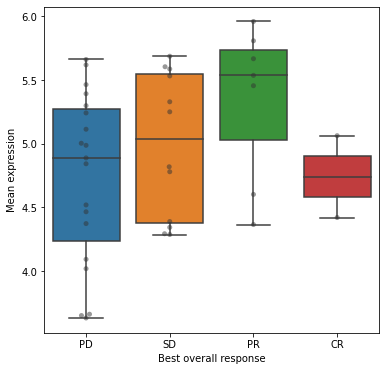

In [113]:
bor_boxplot(data)

In [115]:
mat = get_mat(data)
mat

,PFS,Score,pfs_event
PatientID,,,
pt1,54,5.464433,1
pt10,119,4.343406,1
pt101,612,5.960313,1
pt106,56,5.242039,1
pt17,48,3.661534,1
pt18,519,5.667677,1
pt2,115,5.604786,0
pt23,52,5.330208,1
pt24,50,5.661745,1


In [119]:
cph = CoxPHFitter()
cph.fit(df=mat, duration_col='PFS', 
        event_col='pfs_event')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Score,-0.622447,0.53663,0.295481,-1.20158,-0.043314,0.300719,0.95761,0.0,-2.106553,0.035156,4.830071


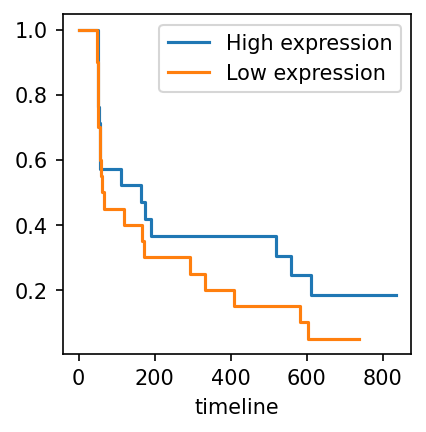

In [118]:
kmf_plot(mat)

### Use receiver genes to predict

In [89]:
n_select = 20
select = receiver.iloc[:n_select,]
common = list(set(select.index).intersection(ge.index))
select = select.iloc[select.index.isin(common),]
select

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
gene,,,,,
GAPDH,1.581859e-142,-1.071368,0.904,0.979,7.258200e-138
NKG7,2.071915e-109,-0.904104,0.688,0.916,9.506776e-105
PRF1,1.060346e-107,-1.046101,0.514,0.792,4.865294e-103
CD38,5.430308e-95,-1.479788,0.189,0.466,2.491643e-90
MALAT1,3.812131e-89,0.486826,1.000,1.000,1.749158e-84
IFI6,1.179608e-79,-1.556274,0.358,0.617,5.412512e-75
IFITM2,1.383622e-75,-0.869484,0.836,0.939,6.348609e-71
CCL5,1.737551e-68,-0.751345,0.856,0.973,7.972578e-64
PSME1,1.053194e-67,-0.632013,0.835,0.933,4.832477e-63


In [90]:
score_table = ge.loc[select.index,].mean(
    axis=0
).reset_index()
score_table.columns = ["PatientID", "Score"]
score_table.head(2)

,PatientID,Score
0,pt101,7.19940
1,pt106,6.18232


In [91]:
data = clin.merge(score_table)
data.head(2)

,PatientID,Sample,SampleType,Cohort,SubtypeEZ,TRTGRP,BOR,myBOR,PFS_SOR,OS_SOR,OS,OSWK,IBOR,PFS,PFSWK,myBOR2,myBOR3,Score
0,pt1,pt1_pre,pre,NIV3-PROG,NaN,NIV3-PROG,PD,PD,0,0,160,22.857143,PROGRESSION,54,7.714286,PD,SDPD,6.967647
1,pt10,pt10_pre,pre,NIV3-NAIVE,NF1,NIV3-NAIVE,SD,SD,0,0,256,36.571429,STABLE DISEASE,119,17.000000,PRCRSD,SDPD,4.217360


In [92]:
data.shape

(41, 18)

Text(0.5, 0, 'Best overall response')

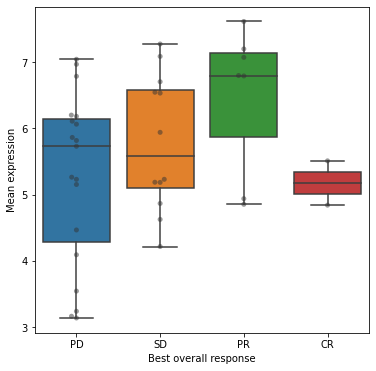

In [98]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

sns.boxplot(x="BOR", 
            y="Score", data=data, 
            order=["PD", "SD", "PR", "CR"], 
            fliersize=0, ax=ax)
sns.swarmplot(x="BOR", 
              y="Score", 
              data=data, 
              order=["PD", "SD", "PR", "CR"], 
              color=".2", alpha=0.5, ax=ax)
ax.set_ylabel("Mean expression")
ax.set_xlabel("Best overall response")

In [94]:
mat = data[["PatientID", "PFS", "PFS_SOR", "Score"]].copy()
# PFS_SOR indicates whether the time to event has been censored
# so we need to do 1 - PFS_SOR to get the event indicator
mat["pfs_event"] = 1 - mat["PFS_SOR"]
mat.drop("PFS_SOR", axis=1, inplace=True)
mat.set_index("PatientID", inplace=True)
mat.head(2)

,PFS,Score,pfs_event
PatientID,,,
pt1,54,6.967647,1
pt10,119,4.217360,1


In [95]:
cph = CoxPHFitter()
cph.fit(df=mat, duration_col='PFS', 
        event_col='pfs_event')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Score,-0.331749,0.717668,0.158429,-0.642263,-0.021234,0.5261,0.978989,0.0,-2.093996,0.03626,4.785462


<AxesSubplot:xlabel='timeline'>

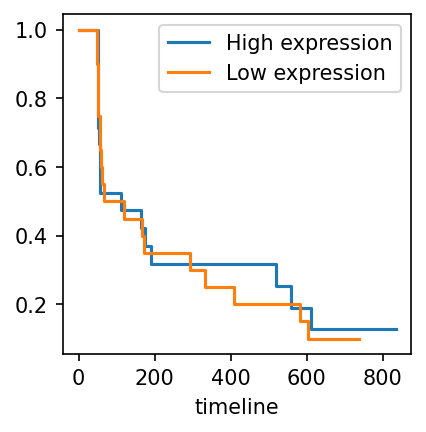

In [99]:
kmf = KaplanMeierFitter()

fig, ax = plt.subplots(dpi=150, figsize=(3, 3))

high_idx = mat.Score >= mat.Score.median()

kmf.fit(mat.PFS[high_idx], mat.pfs_event[high_idx],
        label="High expression")
kmf.plot(ax=ax, ci_show=False)
kmf.fit(mat.PFS[~high_idx], mat.pfs_event[~high_idx],
        label="Low expression")
kmf.plot(ax=ax, ci_show=False)